<a href="https://colab.research.google.com/github/MariiaS/olid/blob/main/Offensive_speech_recognition_in_social_media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 194kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 12.9MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
Mounted at /content/gdrive


The **Offensive Language Identification Dataset (OLID)** contains a collection of 14,200 annotated English tweets using an annotation model that encompasses following three levels:
 
* A: Offensive Language Detection
* B: Categorization of Offensive Language
* C: Offensive Language Target Identification
 
OLID was the official dataset used in the OffensEval: Identifying and Categorizing Offensive Language in Social Media (SemEval 2019 - Task 6) shared task. 

OLID has been in students projects in different universities. To the best of our knowledge, so far it has been used by students at The University of Arizona (USA), Imperial College London (UK), and University of Leeds (UK) Some of the student system papers are available here.

If you used OLID, please refer to this paper:


> Predicting the Type and Target of Offensive Posts in Social Media; Zampieri, Marcos and Malmasi, Shervin and Nakov, Preslav and Rosenthal, Sara and Farra, Noura and Kumar, Ritesh; Proceedings of NAACL; 2019



 

During the experiments with Natural language processing we are going to use **fastai**, which is a framework built on top of PyTorch. **fastai** is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library. fastai includes:

* A new type dispatch system for Python along with a semantic type hierarchy for tensors
* A GPU-optimized computer vision library which can be extended in pure Python
* An optimizer which refactors out the common functionality of modern optimizers into two basic pieces, allowing optimization algorithms to be implemented in 4–5 lines of code
* A novel 2-way callback system that can access any part of the data, model, or optimizer and change it at any point during training
* A new data block API

**fastai** is organized around two main design goals: to be approachable and rapidly productive, while also being deeply hackable and configurable. It is built on top of a hierarchy of lower-level APIs which provide composable building blocks. This way, a user wanting to rewrite part of the high-level API or add particular behavior to suit their needs does not have to learn how to use the lowest level.
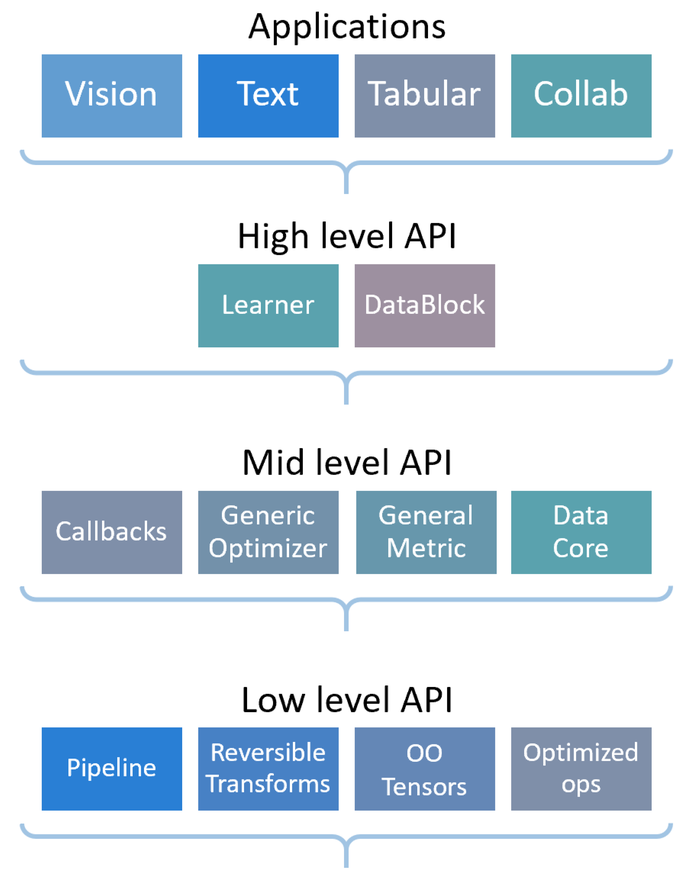

In [ ]:
from fastbook import *
from fastai.text.all import *
import pandas as pd

---
Let's take a look at the data



In [ ]:
pathToFolder = Path("/content/gdrive/MyDrive/Study/NLP/OLIDv1.0/")
data = pd.read_csv(pathToFolder/'olid-training-v1.0.tsv', sep='\t', header=0)
data.head(), data.count

(      id  \
 0  86426   
 1  90194   
 2  16820   
 3  62688   
 4  43605   
 
                                                                                                                                                                                     tweet  \
 0                                                                                                                 @USER She should ask a few native Americans what their take on this is.   
 1                                                                                                                     @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL   
 2  Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT   
 3                                                                                                                       @USER Someone should'veTaken" this piec

Let's take a look how balanced is our dataset for each of the tasks

In [ ]:
data['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

The data for the task A is not balanced, there are about two times more neutral tweets than offensive. Let's take a look at task B and C.

In [ ]:
data['subtask_b'].value_counts() 

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [ ]:
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

As we can see, the data for the tasks B and C is even more unbalanced than for the task A, the difference between the classes reaches 900%, which might lead to the potential risk and problems with the accuracy of the model, as labeling all the data in the task B as TIN will give us the accuracy of the model 88%. 

**Balancing data**

Here: write about down-sample method and up-sample method

In [ ]:
is_offensive = data['subtask_a']=='OFF'
is_neutral = data['subtask_a']=='NOT'
offensive_df = data[is_offensive]
inoffensive_df = data[is_neutral]
offensive_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN


In [ ]:
inoffensive_df_downsampled = inoffensive_df.sample(n = int((len(offensive_df)+len(inoffensive_df))/2), random_state=123)
offensive_df_upsampled = offensive_df.sample(n = int((len(offensive_df)+len(inoffensive_df))/2), replace = True, random_state=123)
offensive_df_upsampled.count

<bound method DataFrame.count of           id  \
10787  58847   
10399  99078   
3917   25082   
12266  82569   
4734   27047   
...      ...   
2972   69456   
11954  29672   
6980   45400   
11424  41056   
5015   15835   

                                                                                                                                                                                                                                                                                   tweet  \
10787                                                                                                                                                                                                           @USER this gave me fucking heart palpitations i'm shaking as i type this   
10399                                                                                                                                                                                                         

In [ ]:
data_balanced = inoffensive_df_downsampled.append(offensive_df_upsampled)
data_balanced = data_balanced.sample(n = len(data_balanced), random_state=123)
data_balanced['subtask_a'].value_counts()

OFF    6620
NOT    6620
Name: subtask_a, dtype: int64

In [ ]:
data_balanced['subtask_b'].value_counts() 

TIN    5804
UNT     816
Name: subtask_b, dtype: int64

In [ ]:
data_balanced['subtask_c'].value_counts() 

IND    3592
GRP    1645
OTH     567
Name: subtask_c, dtype: int64

In [ ]:
data_balanced.to_csv('data_balanced.csv')
dataLoader = TextDataLoaders.from_csv(path='', csv_fname = 'data_balanced.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_a', bs=64, seed = 123)
dataLoader.show_batch(max_n=5, trunc_at=280)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj this is the xxup pic xxup msm showed us in 1 xxrep 3 9 for # xxup jfkjr plane xxunk xxunk xxup fake xxrep 3 ! xxmaj here is a video , showing another pic xxup msm showed of # jfkjr , even xxup more xxup fake xxrep 3 ! xxup url xxmaj article : xxmaj evidence xxmaj of a xxmaj cover up & & xxmaj why official story is in xxup doubt ! "" xxup url xxup url",NOT
1,xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj even pedophiles in interviews will tell you the only way to stop them is to kill them . xxmaj pedophiles even admit to when out of prison they will offend again and that ’s what keeps them alive in prison … the hope of another opportunity to molest an innocent child . xxmaj they are sick f*cks,OFF
2,xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj or there is a completely reasonable explanation why our own xxup f@user xxup xxunk lied to its peeps about a plane hitting the xxunk which is clearly a xxunk … … … 👇 🏼 👇 🏼 👇 🏼 👇 🏼 👇 🏼 👇 🏼 👇 🏼 👇 🏼 👇 🏼 xxup url,OFF
3,xxbos @user # thankstrump xxup this xxup is a ' start ' xxup we xxup must xxup get xxup these ' numbers ' xxup down xxup to 0 ( zero ) xxup by ' any ' xxup and ' all ' xxup means ' necessary ' xxup these xxup so - called ' refugees ' xxup who xxup are xxup not ' terrorist xxup sexual xxup criminals ' xxup must xxup stop xxup being ' cowards ' xxup and ' return ' xxup to ' their xxup native xxup lands ' xxup to ' fight ' # xxup maga # refugeesnotwelcome,OFF
4,xxbos @user xxmaj xxunk the xxmaj patriot 🗽 xxup you xxup have xxup to xxup love our xxup great xxup president xxup trump xxrep 3 ! a xxup xxunk xxup of xxup u.s . xxup steel ! ! xxup changing xxup it ! xxup on xxup trade & & xxup everything xxup for xxup americans ! ! # xxup americafirst # xxup usa # xxup maga # xxup leadership & & # xxup respect # xxup economy # xxup jobs # xxunk # xxup god # xxup bless # xxup trump & & # xxup xxunk 😀 xxrep 3 🗽 😀,NOT


We can see that the library automatically processed all the texts to split then in tokens, adding some special tokens:
- xxbos to indicate the beginning of a text
- xxmaj to indicate the next word was capitalized
- xxup to indicate the next word is written in all caps in the original text
- xxunk to indicate unknown word (one that isn't present in the current vocabulary)
- xxpad to indicate padding, if we need to regroup several texts of different lengths in a batch
- xxrep to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- xxwrep to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

**Write here down what is F1Score**

In [ ]:
learn = text_classifier_learner(dataLoader, AWD_LSTM, drop_mult=0.5, metrics=F1Score())
learn.fine_tune(2)

epoch,train_loss,valid_loss,f1_score,time
0,0.673604,0.639798,0.635472,05:59


epoch,train_loss,valid_loss,f1_score,time
0,0.604468,0.552047,0.710238,16:02


epoch,train_loss,valid_loss,f1_score,time
0,0.604468,0.552047,0.710238,16:02
1,0.557821,0.523063,0.752496,15:57


In [ ]:
learn.save("balancedAmodel")

Path('models/balancedAmodel.pth')

In [ ]:
data.to_csv('data.csv')
dataLoaderUnbalanced = TextDataLoaders.from_csv(path='', csv_fname = 'data.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_a', bs=64, seed=123)
learn_unbalanced = text_classifier_learner(dataLoaderUnbalanced, AWD_LSTM, drop_mult=0.5, metrics=F1Score())
learn_unbalanced.fine_tune(3)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,f1_score,time
0,0.669174,0.637549,0.514964,05:38


epoch,train_loss,valid_loss,f1_score,time
0,0.604958,0.562775,0.538128,15:07
1,0.559104,0.534604,0.555055,15:13


epoch,train_loss,valid_loss,f1_score,time
0,0.604958,0.562775,0.538128,15:07
1,0.559104,0.534604,0.555055,15:13
2,0.521845,0.518756,0.578947,15:12


In [ ]:
learn_unbalanced.save("unbalancedAmodel")

Path('models/unbalancedAmodel.pth')

Let's take a look at the confusion matrix. From here we can notice, that the amount of false positive (FP) is close to the amount of true negative (TN) and there is no disbalance in correctely defined values OFF and NOT.

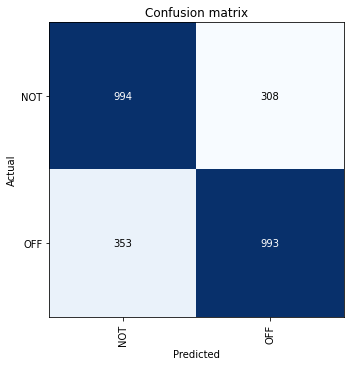

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [ ]:
interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,xxbos @user @user someone should lock her up she is nothing but a bitter and twisted old cow,NOT,OFF,0.9841182231903076,4.142584800720215
1,xxbos @user @user yes he is,OFF,NOT,0.9784372448921204,3.8367867469787598
2,xxbos @user xxmaj holy shit he 's a prophet,NOT,OFF,0.9633510708808899,3.306372880935669
3,xxbos @user xxmaj go roger i quit watching anyway nfl is on the way down the people are moving kids to soccer golf tennis shame but kneelers are killing the game,NOT,OFF,0.9602675437927246,3.225586414337158
4,xxbos @user xxmaj i 'm that nigger no lie,NOT,OFF,0.9589995741844177,3.1941730976104736


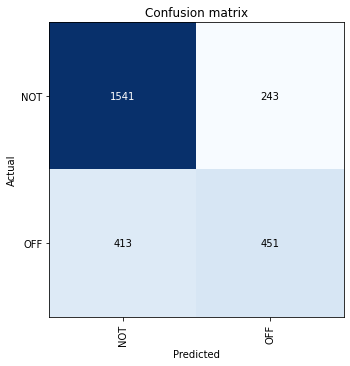

In [ ]:
interpUnbalanced = ClassificationInterpretation.from_learner(learn_unbalanced)
interpUnbalanced.plot_confusion_matrix(figsize=(5,5))

**Work with the text: emojis replacement, @USER and LINK removal**

Let's replace the emojis with the text using the library https://github.com/carpedm20/emoji

In [ ]:
!pip install emoji --upgrade
import emoji
def demojize(tweet):
    return emoji.demojize(tweet)
data_demojized = data_balanced
data_demojized['tweet'] = data_balanced['tweet'].apply(demojize)
data_demojized.head()

     |████████████████████████████████| 133kB 4.8MB/s 


,id,tweet,subtask_a,subtask_b,subtask_c
12807,70171,@USER By wagging her finger at authority figures? Hmmm. ..no. Serena is the definition of a bully. Her frequent on court tantrums are why she is being screened for steroid use more than other players. She appears to have roid-rage.,NOT,NaN,NaN
4154,59407,@USER @USER @USER @USER Not only the Antifa got quite alot Israel supporters. You'll find Israeli flags at the right winger protest just as well. Oh the irony URL,OFF,TIN,OTH
11955,31950,@USER And does this surprise any of us TRUMP SUPPORTERS!!! Not at all... We have heard him accused of everything that can be imagined!!! We still stand BEHIND Our President Donald J TRUMP!!!:United_States::United_States::United_States::United_States::thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up:,NOT,NaN,NaN
2697,63914,@USER @USER @USER @USER I completely believe she will be in GTMO. She is a traitor.,OFF,TIN,IND
5001,13249,@USER Yes...you are exempted...,NOT,NaN,NaN


In [ ]:
data_demojized.to_csv('data_demojized.csv')
dataLoaderDemojized = TextDataLoaders.from_csv(path='', csv_fname = 'data_demojized.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_a', bs=64, seed=123)
learn_demojized = text_classifier_learner(dataLoaderDemojized, AWD_LSTM, drop_mult=0.5, metrics=F1Score())
learn_demojized.fine_tune(2)

In this part, let's remove all the @USER and URL text from the tweets, as it doesn't give any significant information.

In [ ]:
# try also @user mentions, URLs removal and compare
data_url_removed = data_demojized
def remove_url(tweet):
    tweet.replace('USER', '')
    return tweet.replace('URL', '')
def remove_user(tweet):
    return tweet.replace('@USER', '')
data_url_removed['tweet'] = data_demojized['tweet'].apply(remove_url).apply(remove_user)
data_url_removed.head()

,id,tweet,subtask_a,subtask_b,subtask_c
12807,70171,By wagging her finger at authority figures? Hmmm. ..no. Serena is the definition of a bully. Her frequent on court tantrums are why she is being screened for steroid use more than other players. She appears to have roid-rage.,NOT,NaN,NaN
4154,59407,Not only the Antifa got quite alot Israel supporters. You'll find Israeli flags at the right winger protest just as well. Oh the irony,OFF,TIN,OTH
11955,31950,And does this surprise any of us TRUMP SUPPORTERS!!! Not at all... We have heard him accused of everything that can be imagined!!! We still stand BEHIND Our President Donald J TRUMP!!!:United_States::United_States::United_States::United_States::thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up:,NOT,NaN,NaN
2697,63914,I completely believe she will be in GTMO. She is a traitor.,OFF,TIN,IND
5001,13249,Yes...you are exempted...,NOT,NaN,NaN


In [ ]:
data_url_removed.to_csv('data_url_removed.csv')
dataLoaderCleaned = TextDataLoaders.from_csv(path='', csv_fname = 'data_url_removed.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_a', bs=64, seed=123)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn_cleaned = text_classifier_learner(dataLoaderCleaned, AWD_LSTM, drop_mult=0.5, metrics=F1Score())
learn_cleaned.fine_tune(5)

epoch,train_loss,valid_loss,f1_score,time
0,0.644532,0.604323,0.684337,05:27


epoch,train_loss,valid_loss,f1_score,time
0,0.587344,0.550763,0.718773,14:42
1,0.545329,0.499756,0.771598,14:43
2,0.496794,0.460774,0.791082,14:46
3,0.452583,0.443119,0.798115,14:45


epoch,train_loss,valid_loss,f1_score,time
0,0.587344,0.550763,0.718773,14:42
1,0.545329,0.499756,0.771598,14:43
2,0.496794,0.460774,0.791082,14:46
3,0.452583,0.443119,0.798115,14:45
4,0.434605,0.440685,0.803462,14:43


In [ ]:
dataLoaderCleaned.show_batch(max_n=5, trunc_at=280)

,text,category
0,xxbos xxup everyone xxup has xxup to xxup vote xxup red xxup so xxup we xxup do n't xxup lose xxup the xxup house xxup in xxup the xxup midterms : united_states : xxup if xxup we xxup lose xxup the xxup house xxup it 's xxup all xxup over xxrep 4 ! xxup the xxup maga xxup movement xxup will xxup be xxup finished xxrep 4 ! xxup make xxup sure xxup everyone xxup you xxup know xxup is xxup registered xxup to xxup vote xxup red xxrep 4 ! xxup get xxup out xxup and xxup vote xxup red xxrep 4 ! xxup maga xxrep 4 ! xxup kag xxrep 4 ! # xxup walkawayfromdemocrats,NOT
1,"xxbos xxup as xxup you xxup are xxup looking xxup out xxup for xxup me i xxup see xxup your xxup xxunk i xxup am xxup hoping xxup you xxup will xxup get xxup off xxup the xxup xxunk u xxup sensitive xxup to xxup what xxup has xxup happened xxup to xxup me xxup in xxup the xxup middle xxup of xxup the xxup night xxup my xxup car xxup taken xxup while xxup sleeping xxup in xxup it a xxup tow xxup truck xxup removed xxup it xxup to xxup xxunk i xxup know xxup not xxup where xxup late xxup xxunk "" xxup what ? xxup not xxup true .",NOT
2,xxbos xxmaj yes xxmaj melania is wearing her i xxup do n't xxup give a s xxrep 3 _ t xxup jacket xxup and xxup donald xxup xxunk xxup is xxup wearing xxup his xxup go f xxrep 3 _ k xxup yourself xxup jacket xxup just xxup like xxup always . xxup he xxup said xxup that xxup god xxup trump xxup is xxup in xxup da xxup house xxup and xxup he xxup is xxup above xxup the xxup law . xxmaj we did a xxunk job in xxup pr many went without electricity for 6 months but it 's cool .,NOT
3,xxbos # thankstrump xxup this xxup is a ' start ' xxup we xxup must xxup get xxup these ' numbers ' xxup down xxup to 0 ( zero ) xxup by ' any ' xxup and ' all ' xxup means ' necessary ' xxup these xxup so - called ' refugees ' xxup who xxup are xxup not ' terrorist xxup sexual xxup criminals ' xxup must xxup stop xxup being ' cowards ' xxup and ' return ' xxup to ' their xxup native xxup lands ' xxup to ' fight ' # xxup maga # refugeesnotwelcome,OFF
4,"xxbos , … criminal xxmaj complicity in xxup all xxup of xxup this xxup mess ! xxrep 3 - xxmaj last night , xxmaj mr . xxmaj gregg xxmaj jarrett appeared on xxmaj hannity "" ! , … he is xxmaj always xxmaj incredible , and xxmaj he made xxmaj another xxmaj great point when xxmaj he reminded xxmaj all xxmaj of xxup us that "" starting an xxunk xxmaj investigation is a xxmaj crime "" ! xxrep 3 - xxup truth xxup is xxup coming xxup out xxup mueller ! """,OFF


Let's see where we reach the overfitting, but firstly let's save the weights.

In [ ]:
learn_cleaned.save("learn_cleaned")

Path('models/learn_cleaned.pth')

In [ ]:
learn_cleaned.fit_one_cycle(3)

epoch,train_loss,valid_loss,f1_score,time
0,0.449655,0.407966,0.813095,14:46


epoch,train_loss,valid_loss,f1_score,time
0,0.449655,0.407966,0.813095,14:46
1,0.331739,0.369983,0.859452,14:46
2,0.201698,0.371172,0.858447,14:48


**Comparission of AWD_QRNN and AWD_LSTM**

Before moving forward to tuning the model, let's compare AWD_LSTM to AWD_QRNN

In [ ]:
learn_transform = text_classifier_learner(dataLoaderCleaned, AWD_QRNN, drop_mult=0.5, metrics=F1Score())
learn_transform.fine_tune(2)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:227: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


epoch,train_loss,valid_loss,f1_score,time
0,0.721065,0.695697,0.000000,05:07


epoch,train_loss,valid_loss,f1_score,time
0,0.663976,0.646779,0.613546,12:37
1,0.636473,0.641591,0.653832,12:41


We have to train this model more as it doesn't have any daved weights

In [ ]:
learn_transform.fit_one_cycle(5)

epoch,train_loss,valid_loss,f1_score,time
0,0.599839,0.566333,0.690363,12:38
1,0.482354,0.484172,0.764402,12:40
2,0.372392,0.463691,0.803326,12:40
3,0.293978,0.459099,0.814976,12:37
4,0.252858,0.459527,0.819055,12:38


***Usage of SOLID***

In [ ]:
pathToSolid = Path("/content/gdrive/MyDrive/Study/NLP/SOLID/offenseval2020-master/")
data_solid = pd.read_csv(pathToSolid/'1.tsv', sep='\t', header=0)
data_solid.head()

,id,text,average,std
0,1159533701283352576,"First time I heard his name in camp, he seems to be the forgotten guyChristian Covington being disruptive so far today",0.195773,0.187379
1,1159533703522992128,When I go to drink with Tsubaki he would always fall asleep first. His sleeping face looks really innocent and not like him at all. Fufu♪,0.262401,0.145998
2,1159533703758061570,@USER His ass need to stay up 😂😂,0.833391,0.140628
3,1159533703904800769,most important tweet of the day : Fuck Donald Trump and his whole party! thank you for tuning in!,0.565238,0.187498
4,1159533705125343232,You wanna leave? then feel free cus I promise I won’t stop ya. Last time I chased a nigga I ran straight into his potna 🤣,0.664921,0.097098


**Data interpretation and balancing**

In [ ]:
data_labelled = data_solid
def chane_to_labels(average):
  if average>0.5: 
    average='OFF' 
  else: average='NOT'
  return average
data_labelled['average'] = data_labelled['average'].apply(chane_to_labels)
data_labelled.rename(columns={'average': 'subtask_a', 'text':'tweet'}, inplace=True)
data_labelled.head()

,id,tweet,subtask_a,std
0,1159533701283352576,"First time I heard his name in camp, he seems to be the forgotten guyChristian Covington being disruptive so far today",NOT,0.187379
1,1159533703522992128,When I go to drink with Tsubaki he would always fall asleep first. His sleeping face looks really innocent and not like him at all. Fufu♪,NOT,0.145998
2,1159533703758061570,@USER His ass need to stay up 😂😂,OFF,0.140628
3,1159533703904800769,most important tweet of the day : Fuck Donald Trump and his whole party! thank you for tuning in!,OFF,0.187498
4,1159533705125343232,You wanna leave? then feel free cus I promise I won’t stop ya. Last time I chased a nigga I ran straight into his potna 🤣,OFF,0.097098


In [ ]:
data_labelled['tweet'] = data_labelled['tweet'].apply(remove_url).apply(remove_user).apply(demojize)
data_labelled.head()

,id,tweet,subtask_a,std
0,1159533701283352576,"First time I heard his name in camp, he seems to be the forgotten guyChristian Covington being disruptive so far today",NOT,0.187379
1,1159533703522992128,When I go to drink with Tsubaki he would always fall asleep first. His sleeping face looks really innocent and not like him at all. Fufu♪,NOT,0.145998
2,1159533703758061570,His ass need to stay up :face_with_tears_of_joy::face_with_tears_of_joy:,OFF,0.140628
3,1159533703904800769,most important tweet of the day : Fuck Donald Trump and his whole party! thank you for tuning in!,OFF,0.187498
4,1159533705125343232,You wanna leave? then feel free cus I promise I won’t stop ya. Last time I chased a nigga I ran straight into his potna :rolling_on_the_floor_laughing:,OFF,0.097098


Let's take a look how balanced is SOLID

In [ ]:
data_labelled['subtask_a'].value_counts()

NOT    82982
OFF    17017
Name: subtask_a, dtype: int64

In [ ]:
is_offensive_labelled = data_labelled['subtask_a']=='OFF'
is_neutral_labelled = data_labelled['subtask_a']=='NOT'
offensive_df_labelled = data_labelled[is_offensive_labelled]
inoffensive_df_labelled = data_labelled[is_neutral_labelled]
inoffensive_df_downsampled = inoffensive_df_labelled.sample(n = len(offensive_df_labelled), random_state=123)
data_labelled_balanced = inoffensive_df_downsampled.append(offensive_df_labelled)
data_labelled_balanced = data_labelled_balanced.sample(n = len(data_labelled_balanced), random_state=123)
data_labelled_balanced['subtask_a'].value_counts()

NOT    17017
OFF    17017
Name: subtask_a, dtype: int64

In [ ]:
data_labelled_balanced.to_csv('data_labelled_balanced.csv')
dataLoaderLabelled = TextDataLoaders.from_csv(path='', csv_fname = 'data_labelled_balanced.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_a', bs=64, seed=123)
learn_labelled = text_classifier_learner(dataLoaderLabelled, AWD_LSTM, drop_mult=0.5, metrics=F1Score())
learn_labelled.fine_tune(3)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,f1_score,time
0,0.566643,0.511690,0.769889,33:55


epoch,train_loss,valid_loss,f1_score,time
0,0.423799,0.332151,0.849661,1:21:58
1,0.336135,0.279449,0.874945,1:22:13


epoch,train_loss,valid_loss,f1_score,time
0,0.423799,0.332151,0.849661,1:21:58
1,0.336135,0.279449,0.874945,1:22:13
2,0.310021,0.272554,0.880901,1:22:17


In [ ]:
learn_labelled.save("learn_labelled")

Path('models/learn_labelled.pth')

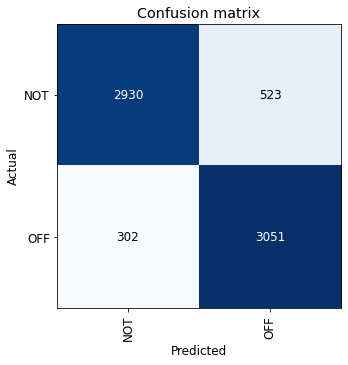

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_labelled)
interp.plot_confusion_matrix(figsize=(5,5))

We are going to take the labels from subtask_b: 
**Categorization of Offensive Language**

Level B categorizes the type of offense:
* Targeted Insult (*TIN*): Posts containing insult/threat to an individual, a group, or others;
* Untargeted (*UNT*): Posts containing nontargeted profanity and swearing. Posts with general profanity are not targeted, but they
contain non-acceptable language.
* Not Offensive (*NaN*): Posts that do not contain offense or profanity



---


We are replacing *NaN* label with *NOT* in column for subtask_b to distinguish also not offensive posts from targeted and untargeted posts.

In [ ]:
data['subtask_b'].fillna('NOT', inplace=True)
data_top = data.head()
data_top

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NOT,NaN
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NOT,NaN


In [ ]:
dataLoader = TextDataLoaders.from_csv(path='', csv_fname = 'cleaned_labels.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_b', bs=64)


In [ ]:
dataLoader.show_batch(max_n=5)

,text,category
0,"xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj this is the xxup pic xxup msm showed us in 1 xxrep 3 9 for # xxup jfkjr plane xxunk xxunk xxup fake xxrep 3 ! xxmaj here is a video , showing another pic xxup msm showed of # jfkjr , even xxup more xxup fake xxrep 3 ! xxup url xxmaj article : xxmaj evidence xxmaj of a xxmaj cover up & & xxmaj why official story is in xxup doubt ! "" xxup url xxup url",NOT
1,xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxup lol ! ! xxmaj same to you ! xxmaj awe ! xxmaj how ’s it feel to want for the first time xxunk ? ! xxmaj is that a new feeling for you ? xxmaj has mommy kept you on the xxunk all these years and now you do n’t know how to fend for yourself ? !,UNT
2,xxbos @user xxup this xxup is a xxup no xxup xxunk . xxup if xxup she xxup stands xxup for xxup what xxup she xxup says xxup she xxup does xxup she xxup has xxup to xxup vote xxup against xxup him xxup if xxup she xxup is xxup lying xxup she xxup deserves xxup to xxup be xxup xxunk xxup and xxup defeated . xxup we xxup will xxup see xxup if xxup she xxup played xxup the xxup pro xxup choice xxup xxunk xxup to xxup get xxup elected xxup or xxup if xxup she xxup is xxup just xxup another xxup xxunk xxup xxunk,TIN
3,"xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user really xxmaj and then "" xxup where in the xxup world does xxmaj antifa fit into xxunk out xxmaj xxunk ? xxmaj and boy oh boy xxmaj xxunk also apparently believes the notion that there are people who actually "" deny climate "" i kid you not ! i think xxmaj rod xxmaj xxunk 's coming to escort xxmaj xxunk back to ' the zone ' """,NOT
4,xxbos @user xxup for xxup the xxup xxunk xxup and xxup the xxup trumps xxup and xxup the xxup xxunk .. xxup but xxup not xxup for xxup we xxup the xxup people xxup or xxup students xxup or xxup teachers xxup and xxup lets xxup not xxup even xxup talk xxup about xxup the xxup things xxup that a xxup majority xxup of xxup the xxup american xxup people xxup expect xxup like xxup healthcare & & xxup gun xxup control ! xxup nothing xxup but $ $ xxup for @user xxup and xxup xxunk !,TIN




---


**ASGD Weight-Dropped LSTM**, or **AWD-LSTM**, is a type of recurrent neural network that employs DropConnect for regularization, as well as NT-ASGD for optimization - non-monotonically triggered averaged SGD - which returns an average of last iterations of weights. Additional regularization techniques employed include variable length backpropagation sequences, variational dropout, embedding dropout, weight tying, independent embedding/hidden size, activation regularization and temporal activation regularization.
[Regularizing and Optimizing LSTM Language Models; Stephen Merity, Nitish Shirish Keskar, Richard Socher; 2017](https://arxiv.org/abs/1708.02182)

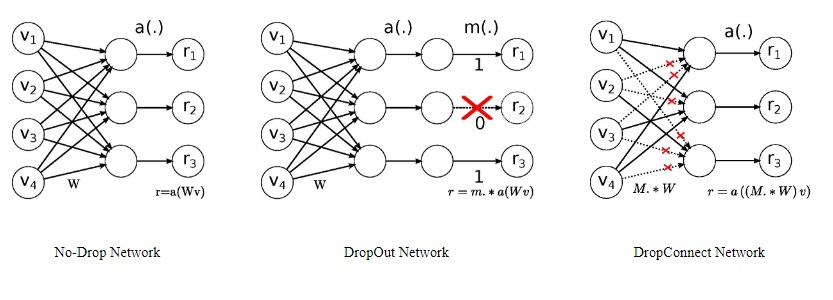

Source – Regularization of Neural Networks using DropConnect

In [ ]:
learn = text_classifier_learner(dataLoader, AWD_LSTM, drop_mult=0.5, metrics=accuracy) #change metrics / macro average / micro average / F-measure

In [ ]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.987557,0.749469,0.660876,05:40


epoch,train_loss,valid_loss,accuracy,time
0,0.720965,0.642520,0.724320,15:20
1,0.627001,0.595938,0.752266,15:20
2,0.574646,0.595119,0.755665,15:24
3,0.510524,0.595486,0.757553,15:15


To analyse the results, we would like to check what are the most difficult texts for the NN

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9) #plot confusion matrix

,input,target,predicted,probability,loss
0,xxbos @user xxup uk xxmaj govt non announcements are the only xxunk and affordable policy under xxmaj labour or xxmaj conservatives for decades . xxmaj designed for a xxunk . xxmaj no immediate xxunk required . xxmaj never likely to ever be implemented . xxmaj its xxunk but sadly it has its xxunk effect .,UNT,NOT,0.9774008393287659,7.5004448890686035
1,xxbos @user xxmaj wow it took 36 years ? xxmaj bet this would of never came up if he had not been choose for supreme xxmaj court . xxmaj shows the liberals for what they really are . xxmaj in a way that 's a good thing 😁,UNT,NOT,0.9828740358352661,6.3210930824279785
2,xxbos @user tbh it xxunk as fuck tho,NOT,TIN,0.6111114025115967,5.945420742034912
3,xxbos @user xxmaj if someone is being too nice to you at happy hour and asking probing questions about what you do at xxmaj xxunk xxmaj citizen … xxunk sure to troll them and say you 're with xxmaj antifa or something .,UNT,NOT,0.9578500986099243,5.82453727722168
4,xxbos @user xxmaj sounds like you 're a xxmaj fascist .,UNT,TIN,0.9162297248840332,5.785214424133301
5,xxbos @user @user @user xxmaj antifa . xxmaj yeah it 's a fringe organization . xxmaj just like those xxunk of humanity i grew up around . xxmaj most of em ended up meth heads and xxunk . xxmaj some are republican alt - right activists . i guess we 're all a product of our environment .,UNT,NOT,0.8298293352127075,5.528747081756592
6,xxbos @user xxmaj it ’s all liberals have . xxmaj they are truly vile .,NOT,TIN,0.9944815635681152,5.362054347991943
7,xxbos @user @user @user @user xxmaj the xxunk system is controlled by liberals and works to xxunk the minds of our children . xxmaj the chains of mental xxunk must be removed in order to save the future of our great nation 🇺 🇸,UNT,NOT,0.829643964767456,5.330833911895752
8,"xxbos @user i mean , the logic "" behind their claim means that in the 90 's the xxmaj liberals felt it was xxup ok for a man to abuse women … that 's xxunk what they are saying … and that the xxmaj conservatives were in the right … right ? """,UNT,NOT,0.897031307220459,5.126399040222168


Indeed, some results can be hardly interpret even by the human eyes. ##take a look at the emoji. Maybe transform them to text

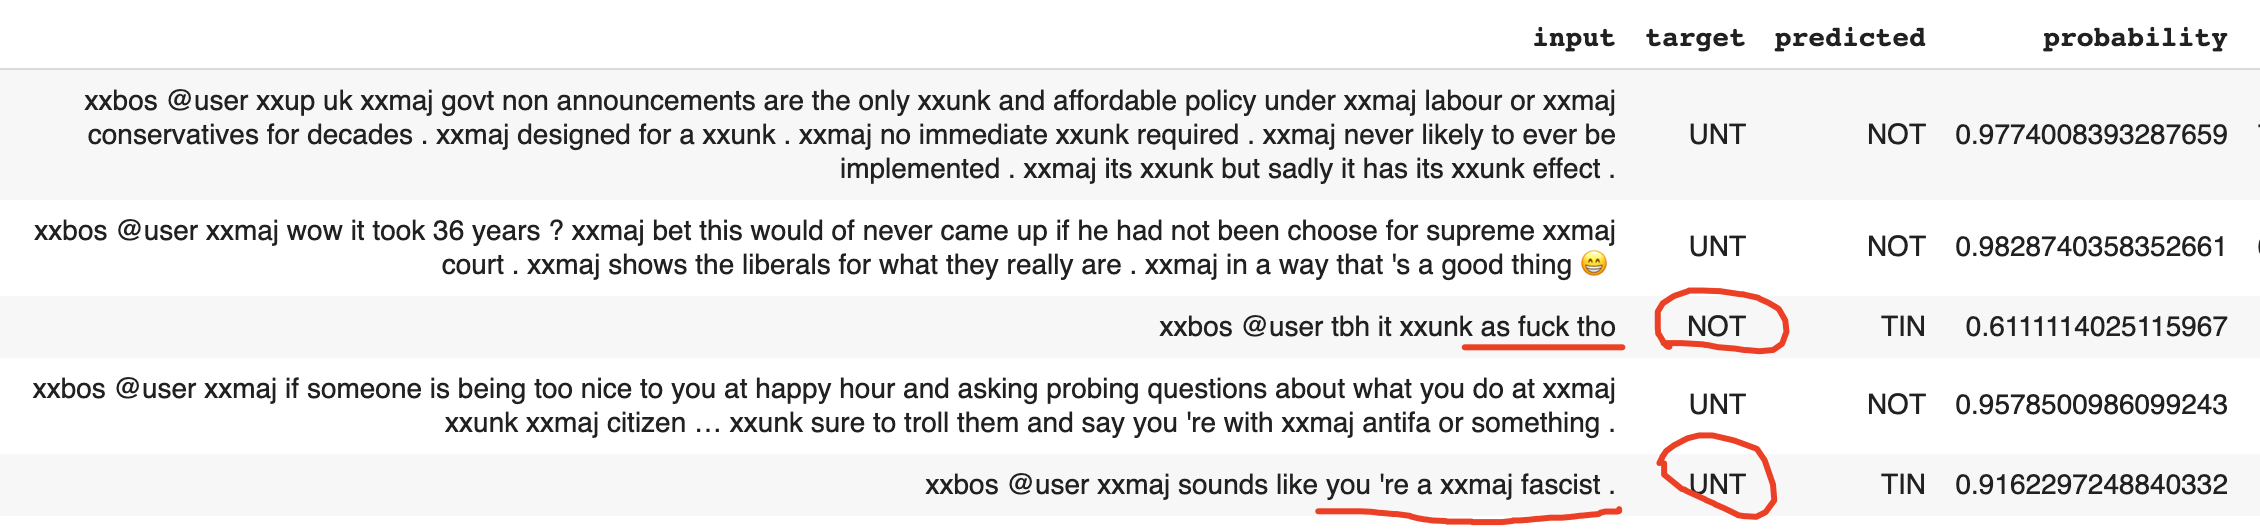

In [ ]:
learn.save("model-4-cycles")

Path('models/model-4-cycles.pth')

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.553911,0.589543,0.760952,15:36
1,0.413072,0.617926,0.755665,15:28


Let's take a look at the results of the report provided by the SemEval-2019 organizers:

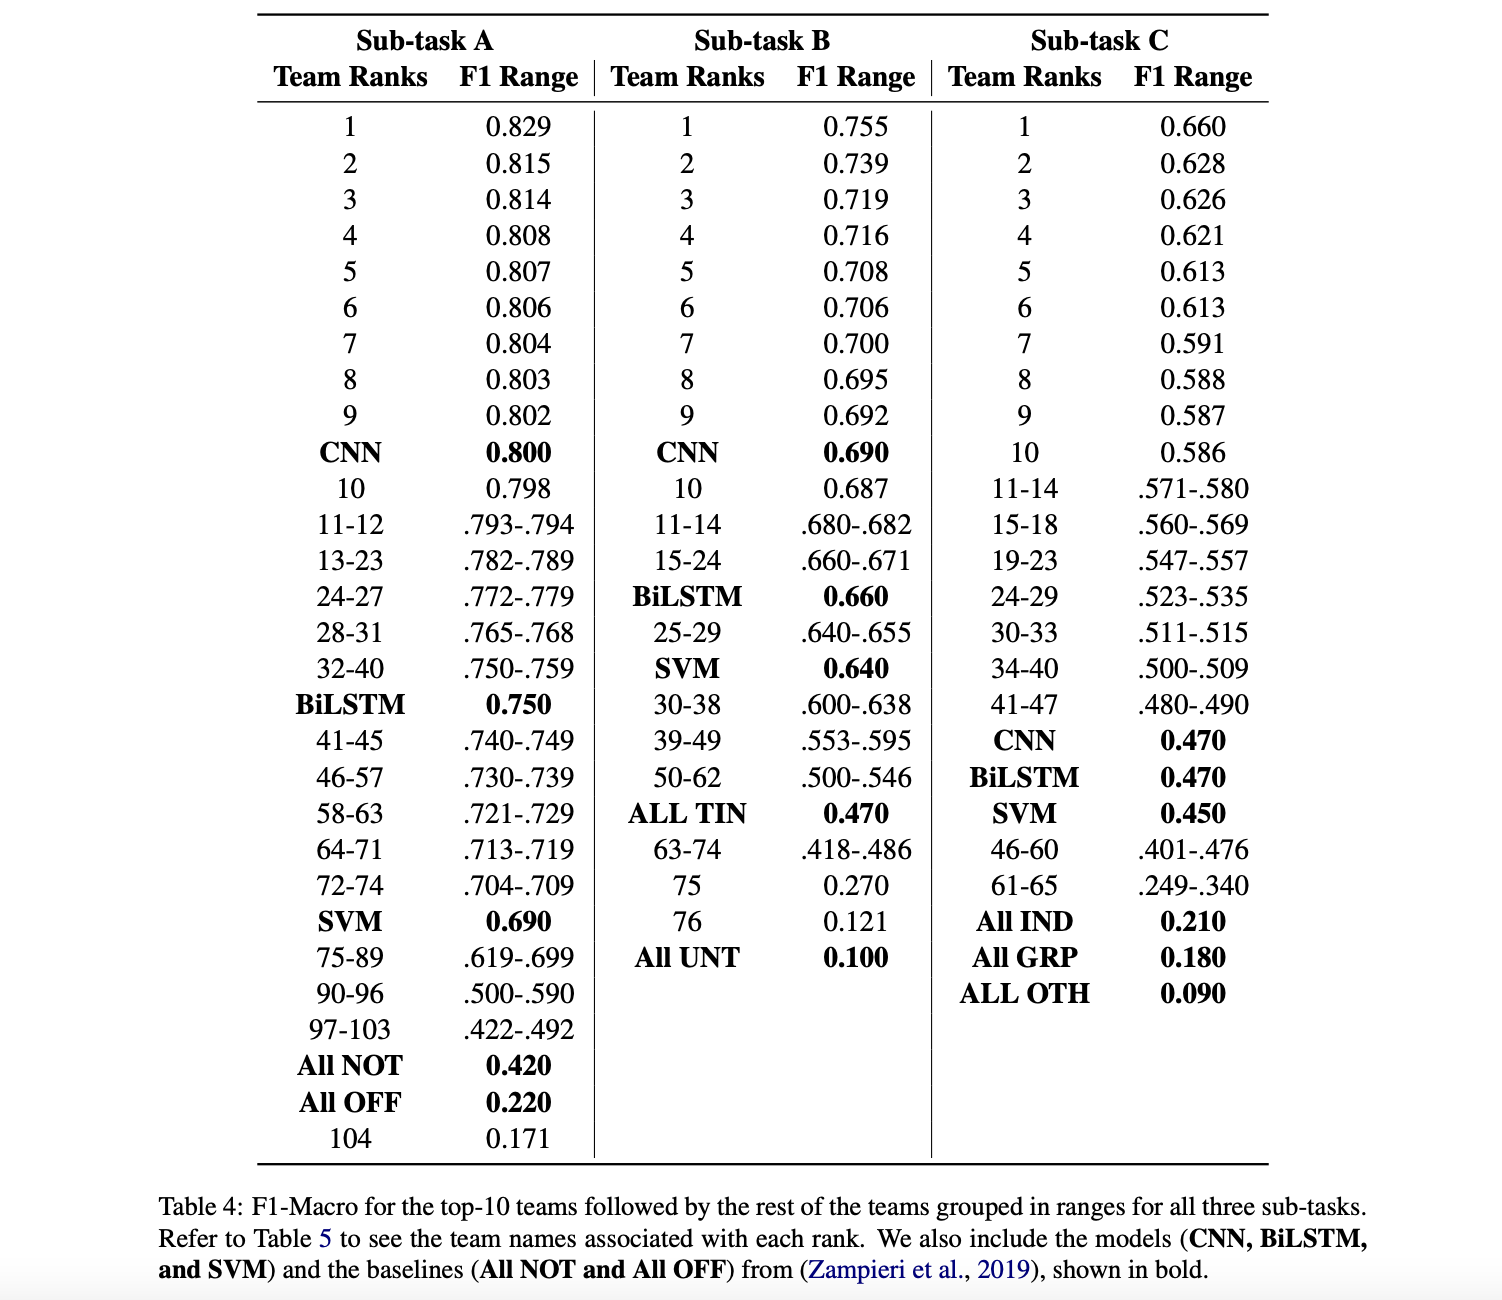

[SemEval-2019 Task 6: Identifying and Categorizing Offensive Language in Social Media (OffensEval)](https://www.aclweb.org/anthology/S19-2010/)